# <center>基于PyTorch的Seq2Seq模型</center>

一个基于PyTorch的Seq2Seq代码展示了如何使用Python和PyTorch构建和训练一个序列到序列的机器翻译模型，进行英语到德语的文本翻译。。

1. 设置环境与模型定义

    * 导入必要的库：导入处理数据和构建模型所需的库，如 torch, numpy, tensorflow.keras 中的 Tokenizer 和 to_categorical。
    * 定义字母表和Tokenizer：设置英文和德文的字母表，并使用 Tokenizer 对每种语言进行字符级的分词处理。
    * Seq2Seq模型定义：定义一个序列到序列的神经网络模型，包含一个LSTM编码器和一个LSTM解码器，以及一个将解码器输出映射到输出维度的全连接层。
2. 模型训练与评估

    * 初始化模型参数和设备：根据模型需要的输入和输出维度初始化模型，并将模型转移到合适的设备（CPU或GPU）上。
    * 训练过程实现：设置损失函数和优化器，使用循环控制进行多个时代的训练，其中包括前向传播、损失计算、梯度反向传播和参数更新。
    * 动态输出训练结果：在训练过程中，动态输出每个批次和每个时代的损失，使用 print 函数或 tqdm 进度条库来增强结果的可视化。
3. 应用与功能实现

    * 模型保存与加载：训练完成后，将模型参数保存到文件，以便未来可以重新加载这些参数进行预测或继续训练。
    * 翻译函数实现：定义一个函数 translate_sentence，用于将英语句子翻译成德语。该函数通过模型预测输出字符，直到遇到结束符或达到最大长度。
---

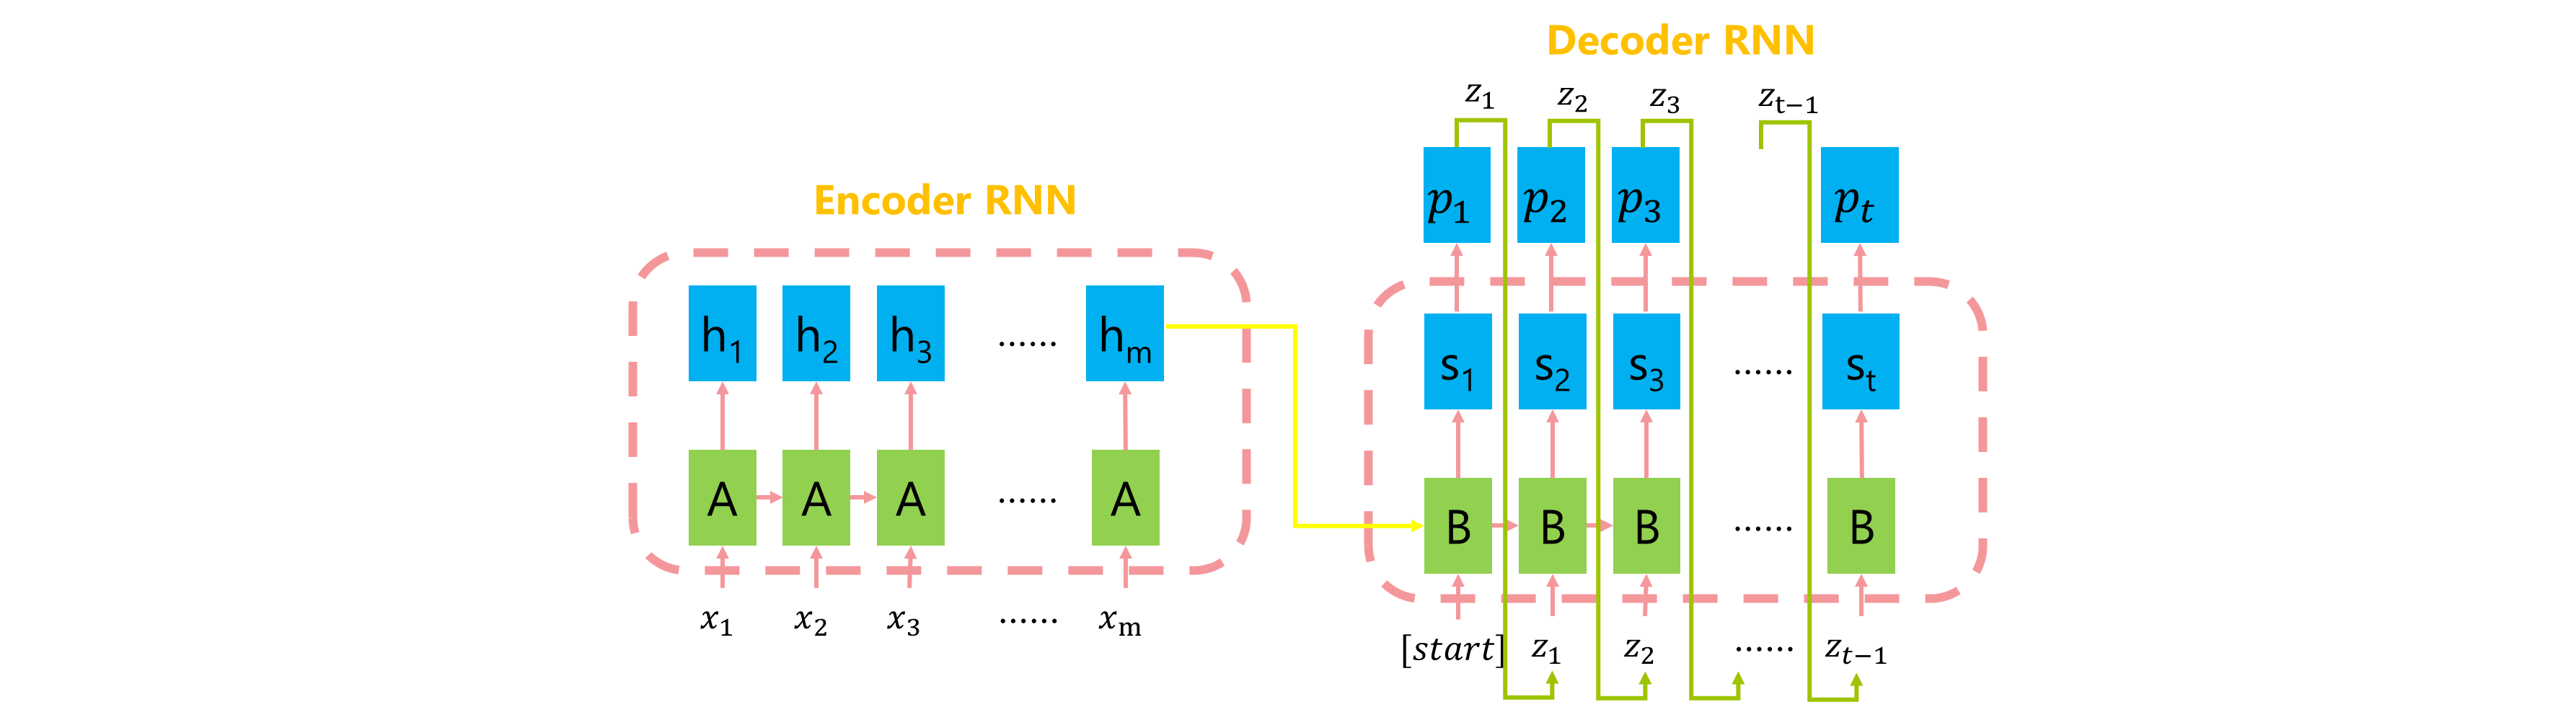

## 导入库

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


## 一. Tokenizer and encoding
- 初始化和配置Tokenizer：为英文和德文分别设置了字符级的分词器，并对字母表进行学习。
- 读取和处理文本数据：从文本文件中读取英德对照句子，进行预处理和分割。
- 数据编码：将英文和德文句子转换成序列，并使用独热编码表示。
- 创建训练数据集：基于编码的序列，创建用于神经网络训练的编码器输入、解码器输入和目标数据。
- 数据集和数据加载器的构建：定义一个PyTorch Dataset 和 DataLoader，以批量方式加载数据，便于后续的模型训练。
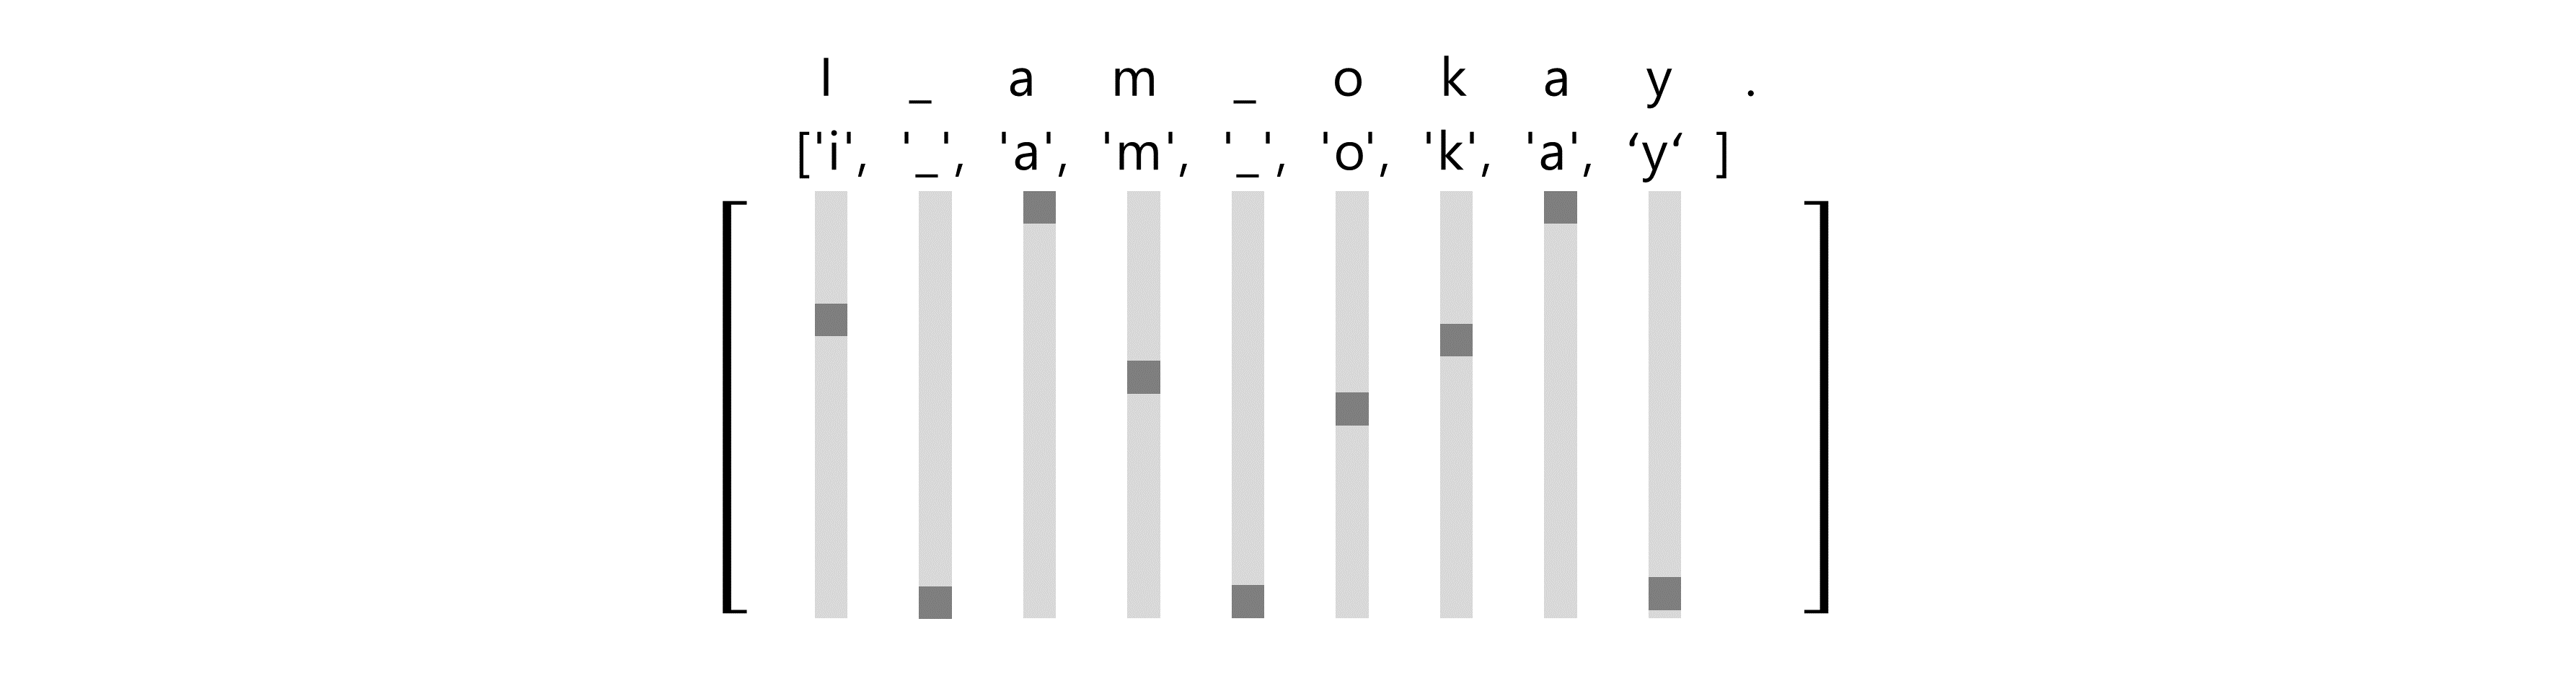

In [2]:
# 定义两种语言的字母表
english_alphabet = 'abcdefghijklmnopqrstuvwxyz'  # 英文字母表
german_alphabet = 'abcdefghijklmnopqrstuvwxyz\t\n'  # 德文字母表，包括\t开始符号和\n结束符号

# 创建英文的Tokenizer，设置为字符级别的分割
english_tokenizer = Tokenizer(char_level=True, lower=True)
english_tokenizer.fit_on_texts([english_alphabet])  # 用英文字母表训练tokenizer
english_word_index = english_tokenizer.word_index  # 获取字符到索引的映射字典

# 创建德文的Tokenizer，设置为字符级别的分割
german_tokenizer = Tokenizer(char_level=True, lower=True)
german_tokenizer.fit_on_texts([german_alphabet])  # 用德文字母表训练tokenizer
german_word_index = german_tokenizer.word_index  # 获取字符到索引的映射字典

# 读取文件夹中的所有文件
data_path = 'deu-eng'  # 数据文件路径
english_sentences = []  # 存储英文句子
german_sentences = []  # 存储德文句子

for file_name in os.listdir(data_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(data_path, file_name)  # 构建文件完整路径
        with open(file_path, 'r', encoding='utf-8') as file:  # 以utf-8编码打开文件
            lines = file.readlines()
            for line in lines:
                parts = line.split('\t')
                if len(parts) == 3:
                    english_sentences.append(parts[0].strip().lower())  # 收集并处理英文句子
                    german_sentences.append('\t' + parts[1].strip().lower() + '\n')  # 收集并处理德文句子，添加开始和结束标记

# 编码英文句子为序列，并转换为one-hot编码
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)
english_onehot = [to_categorical(seq, num_classes=len(english_word_index) + 1) for seq in english_sequences]

# 编码德文句子为序列，并转换为one-hot编码
german_sequences = german_tokenizer.texts_to_sequences(german_sentences)
german_onehot = [to_categorical(seq, num_classes=len(german_word_index) + 1) for seq in german_sequences]

# 初始化训练数据矩阵
max_encoder_seq_length = max([len(seq) for seq in english_sequences])  # 计算最长英文句子的长度
max_decoder_seq_length = max([len(seq) for seq in german_sequences])  # 计算最长德文句子的长度

encoder_input_data = np.zeros((len(english_sentences), max_encoder_seq_length, len(english_word_index) + 1), dtype='float32')
decoder_input_data = np.zeros((len(german_sentences), max_decoder_seq_length, len(german_word_index) + 1), dtype='float32')
decoder_target_data = np.zeros((len(german_sentences), max_decoder_seq_length, len(german_word_index) + 1), dtype='float32')

# 填充数据矩阵
for i, (input_text, target_text) in enumerate(zip(english_onehot, german_onehot)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, :] = char  # 设置编码器输入
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, :] = char  # 设置解码器输入
        if t > 0:
            decoder_target_data[i, t - 1, :] = char  # 设置解码器目标输出，时间步长为t-1


In [3]:
# 打印一些示例数据以验证正确性
print(english_sentences[1110])
print(german_sentences[1110])
# 打印一些示例数据以验证正确性
print("Encoder input data shape:", encoder_input_data.shape)
print("Decoder input data shape:", decoder_input_data.shape)
print("Decoder target data shape:", decoder_target_data.shape)

# 打印前两个样本的编码数据
print("First encoder input sample:\n", encoder_input_data[0])
print("First decoder input sample:\n", decoder_input_data[0])
print("First decoder target sample:\n", decoder_target_data[0])



sit there.
	setz dich dorthin.

Encoder input data shape: (277891, 427, 27)
Decoder input data shape: (277891, 399, 29)
Decoder target data shape: (277891, 399, 29)
First encoder input sample:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First decoder input sample:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First decoder target sample:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 二.建立模型
- 模型结构包括一个LSTM编码器和一个LSTM解码器，以及一个输出层的全连接网络：

1. 编码器：接受输入数据（英语句子的特征表示），并生成一个隐藏状态和一个细胞状态。
2. 解码器：使用编码器的输出状态作为其初始状态，接收另一组输入（通常是目标语言的开始符号或上一时间步的输出），生成翻译的输出。
3. 全连接层：将解码器的输出转换为最终的输出，即目标语言的词汇表中的词的概率分布。
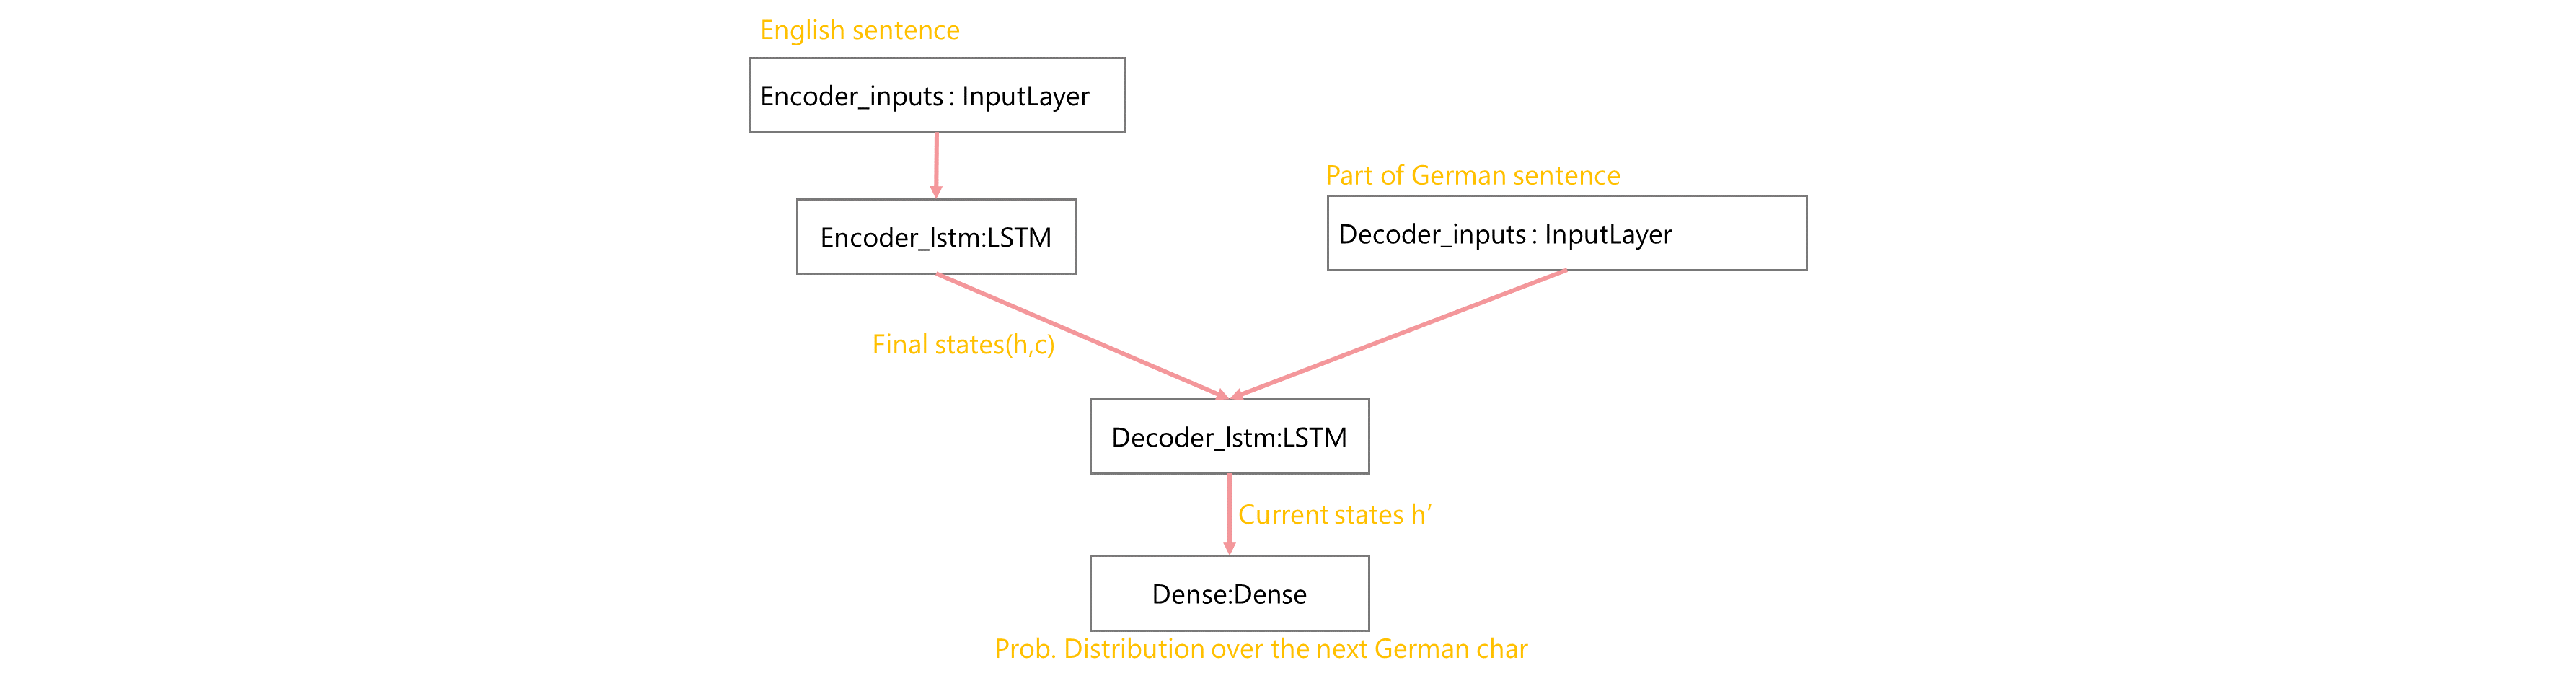

In [4]:
from tensorflow.keras.models import Model  # 从Keras模块中导入Model，用于创建模型
from tensorflow.keras.layers import Input, LSTM, Dense  # 导入Input、LSTM和Dense，这些是构建神经网络的基础层
import numpy as np  # 导入numpy库，用于数学运算和数据操作

# 编码器
encoder_inputs = Input(shape=(None, len(english_word_index) + 1))  # 创建输入层，输入的形状是不定长的时间序列，每个时间步的特征数量是英文字母表的大小加一
encoder_lstm = LSTM(256, return_state=True)  # 创建一个LSTM层，隐藏层单元数量是256，设置return_state为True以获取LSTM的内部状态
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)  # 将输入传递给LSTM层，并接收输出和内部状态
encoder_states = [state_h, state_c]  # 将隐藏状态和细胞状态保存在一个列表中，这些状态将用作解码器的初始状态

# 解码器
decoder_inputs = Input(shape=(None, len(german_word_index) + 1))  # 创建解码器的输入层，与编码器类似，但特征数量对应德文字母表的大小加一
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)  # 创建解码器的LSTM层，设置return_sequences为True以返回所有时间步的输出，return_state为True以返回内部状态
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)  # 将解码器输入和编码器的状态作为初始状态传递给解码器的LSTM层
decoder_dense = Dense(len(german_word_index) + 1, activation='softmax')  # 创建一个全连接层（Dense），输出大小为德文字母表的大小加一，使用softmax激活函数进行分类
decoder_outputs = decoder_dense(decoder_outputs)  # 将解码器LSTM层的输出传递给全连接层，得到最终的输出结果


## 三. 训练
    * 损失函数（categorical_crossentropy）：适用于多分类问题，计算模型输出的概率分布与真实标签的差异。
    * 优化器（rmsprop）：RMSProp（Root Mean Square Propagation）优化器是一种常用的优化算法，主要用于神经网络训练的梯度下降算法的变体。它是对Adagrad优化器的一种改进，旨在解决Adagrad中学习率过快下降的问题。

In [5]:
# 定义训练模型
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)  # 创建模型，指定模型的输入层（编码器和解码器输入）和输出层（解码器输出）

# 编译模型
model.compile(optimizer='rmsprop',  # 设置优化器为rmsprop，这是一种常用的优化算法，适用于处理循环神经网络
              loss='categorical_crossentropy',  # 设置损失函数为分类交叉熵，因为这是一个分类任务
              metrics=['accuracy'])  # 设置评价指标为准确率

# 训练模型
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,  # 输入数据包括编码器输入和解码器输入，以及解码器的目标数据
          batch_size=64,  # 设置每批次处理64个样本
          epochs=5,  # 设置训练5个周期，即整个数据集将被训练5次
          validation_split=0.2)  # 设置将20%的数据用作验证集，以监控训练过程中的性能并防止过拟合

# 保存模型
model.save('seq2seq.h5')  # 保存训练好的模型到本地文件，文件格式为.h5，方便之后的加载和使用


Epoch 1/5
1727/3474 ━━━━━━━━━━━━━━━━━━━━ 32:15 1s/step - accuracy: 0.0088 - loss: 0.2150

KeyboardInterrupt: 

In [ ]:
# 打印模型摘要
model.summary()

NameError: name 'model' is not defined

In [ ]:
# 输入的英文句子
input_sentence = "Hello world"

# 使用英文分词器转换文本为序列
input_sequence = english_tokenizer.texts_to_sequences([input_sentence.lower()])
input_sequence = to_categorical(input_sequence, num_classes=len(english_word_index) + 1)
# 初始化解码器输入，起始字符为 `\t`
decoder_input_data = np.zeros((1, 1, len(german_word_index) + 1))  # 假设只有一个字符，长度为1
decoder_input_data[0, 0, german_word_index['\t']] = 1.0
# 翻译结果
translated_sentence = ''

while True:
    output_tokens, h, c = decoder_lstm.predict([decoder_input_data] + states_value)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = german_word_index.get(sampled_token_index)
    translated_sentence += sampled_char

    # 检查是否达到最大长度或找到停止字符
    if sampled_char == '\n' or len(translated_sentence) > max_decoder_seq_length:
        break

    # 更新解码器的输入为当前的字符
    decoder_input_data = np.zeros((1, 1, len(german_word_index) + 1))
    decoder_input_data[0, 0, sampled_token_index] = 1.0

    # 更新状态
    states_value = [h, c]


print("Translated sentence:", translated_sentence)
